# Pre-process data

While it's possible to do data pre-processing in Colab, using a cloud VM provides better performance which larger datasets.

Colab has limited support for multiprocessing. This makes pre-processing large datasets take 5-10 times more. With all this in mind consider this notebook as an illustration of the approach. 

## Procedure

The pre-processing procedure is the following:

1. Download and open the csv containing training sample metadata from the Cloud Storage Bucket
2. Create a file with download links for files representing each of the target classes
3. Download the source DICOM files
4. Convert DICOM slices into small JPEG pictures
5. Zip and upload the resulting JPEG dataset back to a Cloud Storage Bucket

### Environvent variables and imports

In [ ]:
myProjectID = '%%PUT-YOUR-PROJECT-ID-HERE%%'
bucket_name = '%%PUT-YOUR-BUCKET-ID-HERE%%'

In [ ]:
# Colab specific authentication helpers
from google.colab import auth

# Other imports
import os, shutil
from multiprocessing import Process
import pandas as pd
try:
    import pydicom
except ModuleNotFoundError:
    !pip install pydicom
    import pydicom
from matplotlib import pyplot as plt
import progressbar
from PIL import Image

%matplotlib inline 

In [ ]:
auth.authenticate_user()

### Source data download

Dowload csv with the sample description.

In [ ]:
!gsutil -u $myProjectID cp gs://$bucket_name/sample.csv .

Copying gs://pw35-data-001/sample.csv...
/ [1 files][  8.2 MiB/  8.2 MiB]                                                
Operation completed over 1 objects/8.2 MiB.                                      


In [ ]:
sample_df = pd.read_csv('sample.csv', sep="\t")

tagging_classes = list(sample_df['PV_MRI_assay'].unique())
class_count = len(tagging_classes)
sample_df.head()

,Unnamed: 0,PV_MRI_assay,study_id,series_id,gcs_url
0,22393,T1-weighted post-contrast,1.3.6.1.4.1.14519.5.2.1.7695.4001.569320506186...,1.3.6.1.4.1.14519.5.2.1.7695.4001.149026159959...,gs://idc-open/5f5b0bb1-f2bc-4cc2-91e0-547bc2e4...
1,27223,T1-weighted post-contrast,1.3.6.1.4.1.14519.5.2.1.2531.4003.666089736017...,1.3.6.1.4.1.14519.5.2.1.2531.4003.261424643169...,gs://idc-open/1d2c9f3f-865d-49b1-8e7b-55d055a8...
2,34112,T1-weighted post-contrast,1.3.6.1.4.1.14519.5.2.1.2531.4003.666089736017...,1.3.6.1.4.1.14519.5.2.1.2531.4003.261424643169...,gs://idc-open/1d4c1c72-fa74-4344-998e-159b953c...
3,213,T1-weighted post-contrast,1.3.6.1.4.1.14519.5.2.1.7695.4001.155576204150...,1.3.6.1.4.1.14519.5.2.1.7695.4001.332152476495...,gs://idc-open/7566f7fe-1fa6-4f75-9cc7-50212f93...
4,50080,T1-weighted post-contrast,1.3.6.1.4.1.14519.5.2.1.4591.4001.145527987060...,1.3.6.1.4.1.14519.5.2.1.4591.4001.125672926847...,gs://idc-open/862e33bf-0e35-46f1-875b-7b957dae...


Download source DICOM files from IDC's Cloud Storage Bucket.

In [ ]:
for target_class in tagging_classes:
    target_class_name = target_class.upper().replace(' ', '_')
    gcs_urls = sample_df[sample_df['PV_MRI_assay'] == target_class]['gcs_url']

    # Save download paths
    gcs_urls.to_csv(f'{target_class_name}_gcs_paths.txt', header=False, index=False)

    # Prepare a local download folder
    if os.path.exists(f'./data/{target_class_name}'):
        shutil.rmtree(f'./data/{target_class_name}')
    os.makedirs(f'./data/{target_class_name}', exist_ok=True)

    print(f'Downloading {len(gcs_urls)} files for {target_class_name} class...')
    !cat "$target_class_name"_gcs_paths.txt | gsutil -u $myProjectID -q -m cp -I ./data/$target_class_name
    print(f'Done!')

Done!
Done!
Done!
Done!


### Data conversion

Now that the data has been downloaded to the local storage we can create the dataset.

For each target class folder we woul like to:

1. Open the DICOM
2. Apply a colormap that maps voxel intensities to grayscale
3. Save the resulting image into a 64x64 jpeg

Once the dcm-to-jpeg conversion is done we will zip the images and upload them into a Cloud Storage Bucket.

We create a helper function that will convert a folder with dicoms into a folder of jpeg.

In [ ]:
def prepare_target_jpegs(target_class_name, file_list):
    """Convert the downloaded dicoms to 64x64 jpegs."""
    print(f'Converting {target_class_name} dicoms...')
    bar = progressbar.ProgressBar(maxval=len(file_list),
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ',
                                           progressbar.Percentage()])
    progress_count = 0
    bar.start()

    for object_name in file_list:
        # Read the downloaded dicom file
        ds = pydicom.dcmread(f'./data/{target_class_name}/{object_name}')

        # Apply matplotlib's colormap to the pixel array to get a grayscale picture
        fig = plt.Figure()
        fig.set_size_inches(64, 64)  # Resize all images to be of equal dimensions
        ax = fig.add_subplot(111)
        ax.imshow(ds.pixel_array, cmap=plt.cm.gray)
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1)
        ax.axis('tight'); ax.axis('off')

        # Save image to disk
        fig.savefig(
            f'./images/{target_class_name}/{object_name.replace(".dcm", ".jpg")}',
            dpi=1, bbox_inches='tight',
            transparent=True, facecolor=None, edgecolor=None
            )

        progress_count +=1
        bar.update(progress_count)
    bar.finish()

A straightforward way to prepare the images is to go through all downloaded dicoms in a "for" loop. This is not very efficient as this process can be parallelized.

At the time of creation of this notebook Colab offered very limited support to multiprocessing. Execution of the cell bellow processes 40000 dicoms and takes roughly 45 minutes.

In [ ]:
for target_class in tagging_classes:
    target_class_name = target_class.upper().replace(' ', '_')

    # Prepare a local download folder
    if os.path.exists(f'./images/{target_class_name}'):
        shutil.rmtree(f'./images/{target_class_name}')
    os.makedirs(f'./images/{target_class_name}', exist_ok=True)

    downloaded_files = os.listdir(f'./data/{target_class_name}')
    print(f'\nProcessing {len(downloaded_files)} dicoms...\n')

    prepare_target_jpegs(target_class_name, downloaded_files)

[                                                                        ] N/A%


Processing 10000 dicoms...

Converting T1-WEIGHTED_POST-CONTRAST dicoms...


[========================================================================] 100%
[                                                                        ] N/A%


Processing 10000 dicoms...

Converting T1-WEIGHTED_PRE-CONTRAST dicoms...


[========================================================================] 100%
[                                                                        ] N/A%


Processing 10000 dicoms...

Converting T2-WEIGHTED_IMAGE dicoms...


[========================================================================] 100%
[                                                                        ] N/A%


Processing 10000 dicoms...

Converting T2-WEIGHTED_IMAGE_FLAIR dicoms...


[========================================================================] 100%


As said looping through tens of thousands of individual dicom slices can take a lot of time if done in a loop in a Colab instance. In reality you might want to spin up a more powerful Virtual Machine in Google's Compute Engine and untilize pythons multiprocessing capabilities.

Here's a code example how to launch the processing in a parallelized manner.

```python
subprocesses = []
for target_class in tagging_classes:
    target_class_name = target_class.upper().replace(' ', '_')

    # Prepare a local download folder
    if os.path.exists(f'./images/{target_class_name}'):
        shutil.rmtree(f'./images/{target_class_name}')
    os.makedirs(f'./images/{target_class_name}', exist_ok=True)

    downloaded_files = os.listdir(f'./data/{target_class_name}')
    print(f'\nProcessing {len(downloaded_files)} dicoms...\n')

    process = Process(
        target=prepare_target_jpegs,
        args=(target_class_name, downloaded_files)
        )
    subprocesses.append(process)
    process.start()

# complete the processes
for process in subprocesses:
    process.join()
```


Once the JPEGs are created we can visualize one of the pictures.

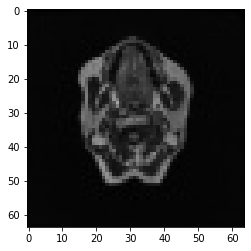

In [ ]:
im = Image.open(f'./images/{target_class_name}/{downloaded_files[0].replace(".dcm", ".jpg")}')
plt.imshow(im)

### Saving the results

Zip the dataset and copy the archive to a Google Cloud Storage Bucket

In [ ]:
# Construct path string for passing it to zip command
target_class_folders = os.listdir('./images')
data_folders = f"./images/{' ./images/'.join(target_class_folders)}"

# Zip the data
!zip -r pw5-gba-tagging-data.zip $data_folders

# Upload the data to a bucket
!gsutil -u $myProjectID cp pw5-gba-tagging-data.zip gs://$bucket_name/

Streaming output truncated to the last 5000 lines.
  adding: images/T2-WEIGHTED_IMAGE/85c4235f-18cd-4b86-b4de-aae4e1002ddd.jpg (deflated 7%)
  adding: images/T2-WEIGHTED_IMAGE/db93ce16-f0be-4ffc-bf15-7c0918b253aa.jpg (deflated 7%)
  adding: images/T2-WEIGHTED_IMAGE/5dfc115d-ebee-4538-a895-72f26b3f6b2a.jpg (deflated 7%)
  adding: images/T2-WEIGHTED_IMAGE/0c36d4c6-e3b3-4769-9b42-89d0b99d639a.jpg (deflated 7%)
  adding: images/T2-WEIGHTED_IMAGE/28992d17-cead-4760-b030-d3ca3fc49487.jpg (deflated 7%)
  adding: images/T2-WEIGHTED_IMAGE/f956b32f-9823-4eb0-9a26-32e88a39833b.jpg (deflated 8%)
  adding: images/T2-WEIGHTED_IMAGE/06ed0fd6-4dfd-4cd5-81de-feb2f5bacf90.jpg (deflated 8%)
  adding: images/T2-WEIGHTED_IMAGE/23051d40-322b-4c0b-9eea-eb3eeb7569d4.jpg (deflated 7%)
  adding: images/T2-WEIGHTED_IMAGE/5b74e023-91ec-4a3b-87d0-ab8be9039e27.jpg (deflated 7%)
  adding: images/T2-WEIGHTED_IMAGE/67ae1dfd-2d6e-470c-9035-cbb73ebd044e.jpg (deflated 10%)
  adding: images/T2-WEIGHTED_IMAGE/3e389e45-095e

---

As the result of data pre-processing we have a `.zip` archive containing JPEGs for 4 target classes in a Could Storage Bucket that can be used to train an image classifier.